# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. Make sure to clone this repository to the directory you're working from. You'll also want to rename it so it has an underscore instead of a dash.

```
git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg
```

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. **You'll need to clone the repo into the folder containing this notebook.** Then download the parameter file using the next cell.

确认已经下载OK

代码改造自 udacity迁移学习，这里只包含一个ipython文件，其他的使用uda的即可

In [1]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',

            pbar.hook)
else:
    print("Parameter file already exists!")

# tensorflow gpu error
def fix_gpu_error():
    if 'session' in locals() and session is not None:
        print('Close interactive session')
        session.close()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Parameter file already exists!


读取类别

In [60]:
def read_pic_path(data_dir):
    contents = os.listdir(data_dir)
    classes = [each for each in contents if os.path.isdir(data_dir + each)]
    return classes

train_dir = 'pigImages/train/'
test_dir = 'pigImages/test/'
valid_dir = 'pigImages/valid/'

# 将目录名称变换为名称的list
train_classes = read_pic_path(train_dir)
print(train_classes)

test_classes = read_pic_path(test_dir)
print(test_classes)

valid_classes = read_pic_path(valid_dir)
print(valid_classes)

['01.pig', '02.pig', '03.pig', '04.pig', '05.pig', '06.pig', '07.pig', '08.pig', '09.pig', '10.pig', '11.pig', '12.pig', '13.pig', '14.pig', '15.pig', '16.pig', '17.pig', '18.pig', '19.pig', '20.pig', '21.pig', '22.pig', '23.pig', '24.pig', '25.pig', '26.pig', '27.pig', '28.pig', '29.pig', '30.pig']
['01.pig', '02.pig', '03.pig', '04.pig', '05.pig', '06.pig', '07.pig', '08.pig', '09.pig', '10.pig', '11.pig', '12.pig', '13.pig', '14.pig', '15.pig', '16.pig', '17.pig', '18.pig', '19.pig', '20.pig', '21.pig', '22.pig', '23.pig', '24.pig', '25.pig', '26.pig', '27.pig', '28.pig', '29.pig', '30.pig']
['01.pig', '02.pig', '03.pig', '04.pig', '05.pig', '06.pig', '07.pig', '08.pig', '09.pig', '10.pig', '11.pig', '12.pig', '13.pig', '14.pig', '15.pig', '16.pig', '17.pig', '18.pig', '19.pig', '20.pig', '21.pig', '22.pig', '23.pig', '24.pig', '25.pig', '26.pig', '27.pig', '28.pig', '29.pig', '30.pig']


预处理图像，分batch

构建迁移模型运行方式

In [63]:
# Set the batch size higher if you can fit in in your GPU memory
def run_transfer_model(data_dir, classes, batch_size = 2):
    codes_list = []
    labels = []
    batch = []
    codes = None
    
    fix_gpu_error()
    
    tf.reset_default_graph()

    with tf.Session() as sess:
        # TODO: Build the vgg network here
        vgg = vgg16.Vgg16()
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope("content_vgg"):
            vgg.build(input_)

        for each in classes:
            print("Starting {} images".format(each))
            class_path = data_dir + each
            # 列出所有的文件名称
            files = os.listdir(class_path)
            for ii, file in enumerate(files, 1):
                # Add images to the current batch
                # utils.load_image crops the input images for us, from the center
            
                # 每次添加一张图片
                img = utils.load_image(os.path.join(class_path, file))
                # 每次处理一张图片
                batch.append(img.reshape((1, 224, 224, 3)))
                # 每次添加一个labels
                labels.append(each)
                
                print("###")
            
                # Running the batch through the network to get the codes
                if ii % batch_size == 0 or ii == len(files):
                
                    # Image batch to pass to VGG network
                    images = np.concatenate(batch)
                    print(len(batch))
                    print(len(images))
                    print(images.shape)
                    # TODO: Get the values from the relu6 layer of the VGG network
                    feed_dict = {input_: images}
                    codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                    # Here I'm building an array of the codes
                    if codes is None:
                        codes = codes_batch
                    else:
                        codes = np.concatenate((codes, codes_batch))
                
                    print(codes.shape)
                
                    # Reset to start building the next batch
                    batch = []
                    print('{} images processed'.format(ii))
    return codes, labels

运行构建好的迁移模型，获得 cnn code

In [64]:
train_codes, train_labels = run_transfer_model(train_dir, train_classes)
test_codes, test_labels = run_transfer_model(test_dir, train_classes)
valid_codes, valid_labels = run_transfer_model(valid_dir, train_classes)

E:\PROJECT\Code\Sample-tranferlearning-vgg\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting 01.pig images
###
###
2
2
(2, 224, 224, 3)
(2, 4096)
2 images processed
###
###
2
2
(2, 224, 224, 3)
(4, 4096)
4 images processed
###
###
2
2
(2, 224, 224, 3)
(6, 4096)
6 images processed
###
###
2
2
(2, 224, 224, 3)
(8, 4096)
8 images processed
###
###
2
2
(2, 224, 224, 3)
(10, 4096)
10 images processed
###
###
2
2
(2, 224, 224, 3)
(12, 4096)
12 images processed
###
###
2
2
(2, 224, 224, 3)
(14, 4096)
14 images processed
###
###
2
2
(2, 224, 224, 3)
(16, 4096)
16 images processed
###
###
2
2
(2, 224, 224, 3)
(18, 4096)
18 images processed
###
###
2
2
(2, 224, 224, 3)
(20, 4096)
20 images processed
###
###
2
2
(2, 224, 224, 3)
(22, 4096)
22 images processed
###
###
2
2
(2, 224, 224, 3)
(24, 4096)
24 images processed
###
###
2
2
(2, 224, 224, 3)
(26, 4096)
26 images processed
###
###
2
2
(2, 224, 224, 3)
(28, 4096)
28 images processed
###
###
2
2
(2, 

10 images processed
###
###
2
2
(2, 224, 224, 3)
(263, 4096)
12 images processed
###
###
2
2
(2, 224, 224, 3)
(265, 4096)
14 images processed
###
###
2
2
(2, 224, 224, 3)
(267, 4096)
16 images processed
###
###
2
2
(2, 224, 224, 3)
(269, 4096)
18 images processed
###
###
2
2
(2, 224, 224, 3)
(271, 4096)
20 images processed
###
###
2
2
(2, 224, 224, 3)
(273, 4096)
22 images processed
###
###
2
2
(2, 224, 224, 3)
(275, 4096)
24 images processed
###
###
2
2
(2, 224, 224, 3)
(277, 4096)
26 images processed
###
###
2
2
(2, 224, 224, 3)
(279, 4096)
28 images processed
###
###
2
2
(2, 224, 224, 3)
(281, 4096)
30 images processed
###
###
2
2
(2, 224, 224, 3)
(283, 4096)
32 images processed
###
###
2
2
(2, 224, 224, 3)
(285, 4096)
34 images processed
###
###
2
2
(2, 224, 224, 3)
(287, 4096)
36 images processed
###
###
2
2
(2, 224, 224, 3)
(289, 4096)
38 images processed
###
###
2
2
(2, 224, 224, 3)
(291, 4096)
40 images processed
###
###
2
2
(2, 224, 224, 3)
(293, 4096)
42 images processed
###


KeyboardInterrupt: 

将cnn code 保存到文件中

In [44]:
import csv

def save2file(codes_file, codes_name, labels_file, labels_name):
    # write codes to file
    with open(codes_name, 'w') as f:
        codes_file.tofile(f)

    # write labels to file    
    with open(labels_name, 'w') as f:
        writer = csv.writer(f, delimiter='\n')
        writer.writerow(labels_file)

save2file(train_codes, 'train_codes', train_labels, 'train_labels')
save2file(test_codes, 'test_codes', test_labels, 'test_labels')
save2file(valid_codes, 'valid_codes', valid_labels, 'valid_labels')


## 检查点

已经保存好的模型，可以从这里开始运行

In [9]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

# tensorflow gpu error
def fix_gpu_error():
    if 'session' in locals() and session is not None:
        print('Close interactive session')
        session.close()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

读取cnn code

In [29]:
# read codes and labels from file
import csv

def read_from_file(codes_name, labels_name):
    with open(labels_name) as f:
        reader = csv.reader(f, delimiter='\n')
        labels = np.array([each for each in reader if len(each) > 0]).squeeze()
    with open(codes_name) as f:
        codes = np.fromfile(f, dtype=np.float32)
        codes = codes.reshape((len(labels), -1))
        print(len(labels))
    return codes, labels

print(train_codes.shape)
train_codes, train_labels = read_from_file('train_codes', 'train_labels')
test_codes, test_labels = read_from_file('test_codes', 'test_labels')
valid_codes, valid_labels = read_from_file('valid_codes', 'valid_labels')
print(train_codes.shape)

(1697, 4096)
1697
180
184
(1697, 4096)


独热编码

In [11]:
from sklearn.preprocessing import LabelBinarizer

def one_hot_encode(labels):
    lb = LabelBinarizer()
    lb.fit(labels)
    return lb.transform(labels)

train_labels_vecs = one_hot_encode(train_labels)
test_labels_vecs = one_hot_encode(test_labels)
valid_labels_vecs = one_hot_encode(valid_labels)
print(train_labels_vecs[0])

lb = LabelBinarizer()
lb.fit(train_labels)
lb.transform(train_labels)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

准备训练，测试，验证的数据

In [12]:
train_x, train_y = train_codes, train_labels_vecs
test_x, test_y = test_codes, test_labels_vecs
val_x, val_y = valid_codes, valid_labels_vecs

print(train_x.shape)

(1697, 4096)


随机化数据

暂未实现

### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [13]:
inputs_ = tf.placeholder(tf.float32, shape=[None, train_x.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, train_y.shape[1]])


# default use ReLU activation func
fc = tf.contrib.layers.fully_connected(inputs_, 1024)
tf.nn.dropout(fc, 0.5)
fc = tf.contrib.layers.fully_connected(fc, 256)
tf.nn.dropout(fc, 0.5)

# output, none activation func
logits = tf.contrib.layers.fully_connected(fc, train_y.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

# Operations for validation/test accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [14]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help. Use the `get_batches` function I wrote before to get your batches like `for x, y in get_batches(train_x, train_y)`. Or write your own!

In [15]:
epochs = 100
batches = 20
iteration = 0

saver = tf.train.Saver()

with tf.Session() as sess:
    fix_gpu_error()
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y, batches):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                loss = sess.run(cost, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc),
                      "Validation Loss: {:.4f}".format(loss))
    saver.save(sess, "checkpoints/pig.ckpt")

Epoch: 1/100 Iteration: 0 Training loss: 8.00354
Epoch: 1/100 Iteration: 1 Training loss: 67.74725
Epoch: 1/100 Iteration: 2 Training loss: 64.87399
Epoch: 1/100 Iteration: 3 Training loss: 53.77161
Epoch: 1/100 Iteration: 4 Training loss: 30.90051
Epoch: 0/100 Iteration: 5 Validation Acc: 0.0489 Validation Loss: 13.8085
Epoch: 1/100 Iteration: 5 Training loss: 15.94573
Epoch: 1/100 Iteration: 6 Training loss: 15.49566
Epoch: 1/100 Iteration: 7 Training loss: 7.30528
Epoch: 1/100 Iteration: 8 Training loss: 10.34359
Epoch: 1/100 Iteration: 9 Training loss: 10.27207
Epoch: 0/100 Iteration: 10 Validation Acc: 0.0543 Validation Loss: 10.0943
Epoch: 1/100 Iteration: 10 Training loss: 13.03475
Epoch: 1/100 Iteration: 11 Training loss: 9.62127
Epoch: 1/100 Iteration: 12 Training loss: 6.84704
Epoch: 1/100 Iteration: 13 Training loss: 12.63351
Epoch: 1/100 Iteration: 14 Training loss: 19.40240
Epoch: 0/100 Iteration: 15 Validation Acc: 0.0435 Validation Loss: 9.5383
Epoch: 1/100 Iteration: 15

Epoch: 7/100 Iteration: 126 Training loss: 3.07389
Epoch: 7/100 Iteration: 127 Training loss: 3.01248
Epoch: 7/100 Iteration: 128 Training loss: 3.04945
Epoch: 7/100 Iteration: 129 Training loss: 2.88897
Epoch: 6/100 Iteration: 130 Validation Acc: 0.1576 Validation Loss: 3.0916
Epoch: 7/100 Iteration: 130 Training loss: 2.79586
Epoch: 7/100 Iteration: 131 Training loss: 2.66626
Epoch: 7/100 Iteration: 132 Training loss: 3.05885
Epoch: 7/100 Iteration: 133 Training loss: 3.29154
Epoch: 7/100 Iteration: 134 Training loss: 2.97122
Epoch: 6/100 Iteration: 135 Validation Acc: 0.1141 Validation Loss: 3.3125
Epoch: 7/100 Iteration: 135 Training loss: 3.23210
Epoch: 7/100 Iteration: 136 Training loss: 3.68959
Epoch: 7/100 Iteration: 137 Training loss: 3.52916
Epoch: 7/100 Iteration: 138 Training loss: 3.48166
Epoch: 7/100 Iteration: 139 Training loss: 3.30874
Epoch: 6/100 Iteration: 140 Validation Acc: 0.1087 Validation Loss: 3.2835
Epoch: 8/100 Iteration: 140 Training loss: 1.88349
Epoch: 8/1

Epoch: 13/100 Iteration: 249 Training loss: 1.15504
Epoch: 12/100 Iteration: 250 Validation Acc: 0.2446 Validation Loss: 2.8985
Epoch: 13/100 Iteration: 250 Training loss: 2.26195
Epoch: 13/100 Iteration: 251 Training loss: 3.00061
Epoch: 13/100 Iteration: 252 Training loss: 3.22823
Epoch: 13/100 Iteration: 253 Training loss: 2.35238
Epoch: 13/100 Iteration: 254 Training loss: 2.05847
Epoch: 12/100 Iteration: 255 Validation Acc: 0.2772 Validation Loss: 2.7563
Epoch: 13/100 Iteration: 255 Training loss: 2.59513
Epoch: 13/100 Iteration: 256 Training loss: 3.31472
Epoch: 13/100 Iteration: 257 Training loss: 2.98200
Epoch: 13/100 Iteration: 258 Training loss: 2.35199
Epoch: 13/100 Iteration: 259 Training loss: 2.83812
Epoch: 12/100 Iteration: 260 Validation Acc: 0.2337 Validation Loss: 2.9727
Epoch: 14/100 Iteration: 260 Training loss: 1.31259
Epoch: 14/100 Iteration: 261 Training loss: 1.26783
Epoch: 14/100 Iteration: 262 Training loss: 2.44647
Epoch: 14/100 Iteration: 263 Training loss: 

Epoch: 19/100 Iteration: 370 Training loss: 1.68079
Epoch: 19/100 Iteration: 371 Training loss: 1.41457
Epoch: 19/100 Iteration: 372 Training loss: 1.89481
Epoch: 19/100 Iteration: 373 Training loss: 1.25592
Epoch: 19/100 Iteration: 374 Training loss: 1.37489
Epoch: 18/100 Iteration: 375 Validation Acc: 0.3478 Validation Loss: 2.6367
Epoch: 19/100 Iteration: 375 Training loss: 2.66473
Epoch: 19/100 Iteration: 376 Training loss: 2.76828
Epoch: 19/100 Iteration: 377 Training loss: 2.64394
Epoch: 19/100 Iteration: 378 Training loss: 0.92909
Epoch: 19/100 Iteration: 379 Training loss: 1.90371
Epoch: 18/100 Iteration: 380 Validation Acc: 0.3641 Validation Loss: 2.5584
Epoch: 20/100 Iteration: 380 Training loss: 1.13416
Epoch: 20/100 Iteration: 381 Training loss: 1.12397
Epoch: 20/100 Iteration: 382 Training loss: 2.14946
Epoch: 20/100 Iteration: 383 Training loss: 1.69383
Epoch: 20/100 Iteration: 384 Training loss: 2.36635
Epoch: 19/100 Iteration: 385 Validation Acc: 0.3533 Validation Loss:

Epoch: 25/100 Iteration: 492 Training loss: 0.71181
Epoch: 25/100 Iteration: 493 Training loss: 0.91946
Epoch: 25/100 Iteration: 494 Training loss: 0.97425
Epoch: 24/100 Iteration: 495 Validation Acc: 0.4076 Validation Loss: 3.0399
Epoch: 25/100 Iteration: 495 Training loss: 1.63210
Epoch: 25/100 Iteration: 496 Training loss: 3.05471
Epoch: 25/100 Iteration: 497 Training loss: 2.99987
Epoch: 25/100 Iteration: 498 Training loss: 1.00690
Epoch: 25/100 Iteration: 499 Training loss: 0.97792
Epoch: 24/100 Iteration: 500 Validation Acc: 0.3750 Validation Loss: 2.8967
Epoch: 26/100 Iteration: 500 Training loss: 1.24079
Epoch: 26/100 Iteration: 501 Training loss: 0.43253
Epoch: 26/100 Iteration: 502 Training loss: 1.80584
Epoch: 26/100 Iteration: 503 Training loss: 1.78567
Epoch: 26/100 Iteration: 504 Training loss: 2.29411
Epoch: 25/100 Iteration: 505 Validation Acc: 0.4185 Validation Loss: 2.2572
Epoch: 26/100 Iteration: 505 Training loss: 1.40992
Epoch: 26/100 Iteration: 506 Training loss: 

Epoch: 31/100 Iteration: 614 Training loss: 0.25041
Epoch: 30/100 Iteration: 615 Validation Acc: 0.5435 Validation Loss: 1.9897
Epoch: 31/100 Iteration: 615 Training loss: 0.27277
Epoch: 31/100 Iteration: 616 Training loss: 0.64098
Epoch: 31/100 Iteration: 617 Training loss: 0.51816
Epoch: 31/100 Iteration: 618 Training loss: 0.22981
Epoch: 31/100 Iteration: 619 Training loss: 0.54454
Epoch: 30/100 Iteration: 620 Validation Acc: 0.5054 Validation Loss: 2.3671
Epoch: 32/100 Iteration: 620 Training loss: 0.29221
Epoch: 32/100 Iteration: 621 Training loss: 0.35793
Epoch: 32/100 Iteration: 622 Training loss: 2.65346
Epoch: 32/100 Iteration: 623 Training loss: 0.94220
Epoch: 32/100 Iteration: 624 Training loss: 1.37932
Epoch: 31/100 Iteration: 625 Validation Acc: 0.5435 Validation Loss: 2.4111
Epoch: 32/100 Iteration: 625 Training loss: 0.77734
Epoch: 32/100 Iteration: 626 Training loss: 0.27419
Epoch: 32/100 Iteration: 627 Training loss: 0.36221
Epoch: 32/100 Iteration: 628 Training loss: 

Epoch: 37/100 Iteration: 735 Training loss: 0.03794
Epoch: 37/100 Iteration: 736 Training loss: 0.11108
Epoch: 37/100 Iteration: 737 Training loss: 0.05294
Epoch: 37/100 Iteration: 738 Training loss: 0.02616
Epoch: 37/100 Iteration: 739 Training loss: 0.06794
Epoch: 36/100 Iteration: 740 Validation Acc: 0.6957 Validation Loss: 1.4184
Epoch: 38/100 Iteration: 740 Training loss: 0.12827
Epoch: 38/100 Iteration: 741 Training loss: 0.04669
Epoch: 38/100 Iteration: 742 Training loss: 0.11765
Epoch: 38/100 Iteration: 743 Training loss: 0.13683
Epoch: 38/100 Iteration: 744 Training loss: 0.13359
Epoch: 37/100 Iteration: 745 Validation Acc: 0.7011 Validation Loss: 1.3823
Epoch: 38/100 Iteration: 745 Training loss: 0.07751
Epoch: 38/100 Iteration: 746 Training loss: 0.05517
Epoch: 38/100 Iteration: 747 Training loss: 0.01829
Epoch: 38/100 Iteration: 748 Training loss: 0.02246
Epoch: 38/100 Iteration: 749 Training loss: 0.06363
Epoch: 37/100 Iteration: 750 Validation Acc: 0.7065 Validation Loss:

Epoch: 43/100 Iteration: 857 Training loss: 0.00956
Epoch: 43/100 Iteration: 858 Training loss: 0.00432
Epoch: 43/100 Iteration: 859 Training loss: 0.01227
Epoch: 42/100 Iteration: 860 Validation Acc: 0.7500 Validation Loss: 1.2125
Epoch: 44/100 Iteration: 860 Training loss: 0.00930
Epoch: 44/100 Iteration: 861 Training loss: 0.00634
Epoch: 44/100 Iteration: 862 Training loss: 0.03154
Epoch: 44/100 Iteration: 863 Training loss: 0.02755
Epoch: 44/100 Iteration: 864 Training loss: 0.03201
Epoch: 43/100 Iteration: 865 Validation Acc: 0.7446 Validation Loss: 1.2190
Epoch: 44/100 Iteration: 865 Training loss: 0.02207
Epoch: 44/100 Iteration: 866 Training loss: 0.00892
Epoch: 44/100 Iteration: 867 Training loss: 0.00853
Epoch: 44/100 Iteration: 868 Training loss: 0.00623
Epoch: 44/100 Iteration: 869 Training loss: 0.01294
Epoch: 43/100 Iteration: 870 Validation Acc: 0.7446 Validation Loss: 1.2356
Epoch: 44/100 Iteration: 870 Training loss: 0.00688
Epoch: 44/100 Iteration: 871 Training loss: 

Epoch: 49/100 Iteration: 979 Training loss: 0.00569
Epoch: 48/100 Iteration: 980 Validation Acc: 0.7554 Validation Loss: 1.2172
Epoch: 50/100 Iteration: 980 Training loss: 0.00462
Epoch: 50/100 Iteration: 981 Training loss: 0.00355
Epoch: 50/100 Iteration: 982 Training loss: 0.01367
Epoch: 50/100 Iteration: 983 Training loss: 0.01360
Epoch: 50/100 Iteration: 984 Training loss: 0.01455
Epoch: 49/100 Iteration: 985 Validation Acc: 0.7554 Validation Loss: 1.2140
Epoch: 50/100 Iteration: 985 Training loss: 0.00950
Epoch: 50/100 Iteration: 986 Training loss: 0.00479
Epoch: 50/100 Iteration: 987 Training loss: 0.00494
Epoch: 50/100 Iteration: 988 Training loss: 0.00342
Epoch: 50/100 Iteration: 989 Training loss: 0.00702
Epoch: 49/100 Iteration: 990 Validation Acc: 0.7554 Validation Loss: 1.2146
Epoch: 50/100 Iteration: 990 Training loss: 0.00335
Epoch: 50/100 Iteration: 991 Training loss: 0.00876
Epoch: 50/100 Iteration: 992 Training loss: 0.00507
Epoch: 50/100 Iteration: 993 Training loss: 

Epoch: 55/100 Iteration: 1099 Training loss: 0.00338
Epoch: 54/100 Iteration: 1100 Validation Acc: 0.7609 Validation Loss: 1.2111
Epoch: 56/100 Iteration: 1100 Training loss: 0.00280
Epoch: 56/100 Iteration: 1101 Training loss: 0.00234
Epoch: 56/100 Iteration: 1102 Training loss: 0.00788
Epoch: 56/100 Iteration: 1103 Training loss: 0.00844
Epoch: 56/100 Iteration: 1104 Training loss: 0.00885
Epoch: 55/100 Iteration: 1105 Validation Acc: 0.7609 Validation Loss: 1.2056
Epoch: 56/100 Iteration: 1105 Training loss: 0.00550
Epoch: 56/100 Iteration: 1106 Training loss: 0.00309
Epoch: 56/100 Iteration: 1107 Training loss: 0.00315
Epoch: 56/100 Iteration: 1108 Training loss: 0.00227
Epoch: 56/100 Iteration: 1109 Training loss: 0.00428
Epoch: 55/100 Iteration: 1110 Validation Acc: 0.7609 Validation Loss: 1.2045
Epoch: 56/100 Iteration: 1110 Training loss: 0.00206
Epoch: 56/100 Iteration: 1111 Training loss: 0.00564
Epoch: 56/100 Iteration: 1112 Training loss: 0.00331
Epoch: 56/100 Iteration: 11

Epoch: 61/100 Iteration: 1218 Training loss: 0.00106
Epoch: 61/100 Iteration: 1219 Training loss: 0.00223
Epoch: 60/100 Iteration: 1220 Validation Acc: 0.7663 Validation Loss: 1.2055
Epoch: 62/100 Iteration: 1220 Training loss: 0.00174
Epoch: 62/100 Iteration: 1221 Training loss: 0.00154
Epoch: 62/100 Iteration: 1222 Training loss: 0.00546
Epoch: 62/100 Iteration: 1223 Training loss: 0.00567
Epoch: 62/100 Iteration: 1224 Training loss: 0.00608
Epoch: 61/100 Iteration: 1225 Validation Acc: 0.7663 Validation Loss: 1.2014
Epoch: 62/100 Iteration: 1225 Training loss: 0.00370
Epoch: 62/100 Iteration: 1226 Training loss: 0.00214
Epoch: 62/100 Iteration: 1227 Training loss: 0.00214
Epoch: 62/100 Iteration: 1228 Training loss: 0.00158
Epoch: 62/100 Iteration: 1229 Training loss: 0.00287
Epoch: 61/100 Iteration: 1230 Validation Acc: 0.7663 Validation Loss: 1.1963
Epoch: 62/100 Iteration: 1230 Training loss: 0.00141
Epoch: 62/100 Iteration: 1231 Training loss: 0.00399
Epoch: 62/100 Iteration: 12

Epoch: 67/100 Iteration: 1337 Training loss: 0.00138
Epoch: 67/100 Iteration: 1338 Training loss: 0.00078
Epoch: 67/100 Iteration: 1339 Training loss: 0.00158
Epoch: 66/100 Iteration: 1340 Validation Acc: 0.7772 Validation Loss: 1.2038
Epoch: 68/100 Iteration: 1340 Training loss: 0.00128
Epoch: 68/100 Iteration: 1341 Training loss: 0.00109
Epoch: 68/100 Iteration: 1342 Training loss: 0.00406
Epoch: 68/100 Iteration: 1343 Training loss: 0.00405
Epoch: 68/100 Iteration: 1344 Training loss: 0.00417
Epoch: 67/100 Iteration: 1345 Validation Acc: 0.7772 Validation Loss: 1.2013
Epoch: 68/100 Iteration: 1345 Training loss: 0.00250
Epoch: 68/100 Iteration: 1346 Training loss: 0.00161
Epoch: 68/100 Iteration: 1347 Training loss: 0.00157
Epoch: 68/100 Iteration: 1348 Training loss: 0.00113
Epoch: 68/100 Iteration: 1349 Training loss: 0.00205
Epoch: 67/100 Iteration: 1350 Validation Acc: 0.7772 Validation Loss: 1.2003
Epoch: 68/100 Iteration: 1350 Training loss: 0.00102
Epoch: 68/100 Iteration: 13

Epoch: 73/100 Iteration: 1456 Training loss: 0.00137
Epoch: 73/100 Iteration: 1457 Training loss: 0.00105
Epoch: 73/100 Iteration: 1458 Training loss: 0.00061
Epoch: 73/100 Iteration: 1459 Training loss: 0.00118
Epoch: 72/100 Iteration: 1460 Validation Acc: 0.7826 Validation Loss: 1.2051
Epoch: 74/100 Iteration: 1460 Training loss: 0.00094
Epoch: 74/100 Iteration: 1461 Training loss: 0.00084
Epoch: 74/100 Iteration: 1462 Training loss: 0.00303
Epoch: 74/100 Iteration: 1463 Training loss: 0.00310
Epoch: 74/100 Iteration: 1464 Training loss: 0.00318
Epoch: 73/100 Iteration: 1465 Validation Acc: 0.7826 Validation Loss: 1.2027
Epoch: 74/100 Iteration: 1465 Training loss: 0.00193
Epoch: 74/100 Iteration: 1466 Training loss: 0.00120
Epoch: 74/100 Iteration: 1467 Training loss: 0.00118
Epoch: 74/100 Iteration: 1468 Training loss: 0.00087
Epoch: 74/100 Iteration: 1469 Training loss: 0.00151
Epoch: 73/100 Iteration: 1470 Validation Acc: 0.7826 Validation Loss: 1.2035
Epoch: 74/100 Iteration: 14

Epoch: 79/100 Iteration: 1575 Training loss: 0.00101
Epoch: 79/100 Iteration: 1576 Training loss: 0.00108
Epoch: 79/100 Iteration: 1577 Training loss: 0.00084
Epoch: 79/100 Iteration: 1578 Training loss: 0.00047
Epoch: 79/100 Iteration: 1579 Training loss: 0.00093
Epoch: 78/100 Iteration: 1580 Validation Acc: 0.7935 Validation Loss: 1.2098
Epoch: 80/100 Iteration: 1580 Training loss: 0.00075
Epoch: 80/100 Iteration: 1581 Training loss: 0.00065
Epoch: 80/100 Iteration: 1582 Training loss: 0.00237
Epoch: 80/100 Iteration: 1583 Training loss: 0.00241
Epoch: 80/100 Iteration: 1584 Training loss: 0.00244
Epoch: 79/100 Iteration: 1585 Validation Acc: 0.7935 Validation Loss: 1.2078
Epoch: 80/100 Iteration: 1585 Training loss: 0.00150
Epoch: 80/100 Iteration: 1586 Training loss: 0.00097
Epoch: 80/100 Iteration: 1587 Training loss: 0.00090
Epoch: 80/100 Iteration: 1588 Training loss: 0.00068
Epoch: 80/100 Iteration: 1589 Training loss: 0.00123
Epoch: 79/100 Iteration: 1590 Validation Acc: 0.788

Epoch: 84/100 Iteration: 1695 Validation Acc: 0.7989 Validation Loss: 1.2148
Epoch: 85/100 Iteration: 1695 Training loss: 0.00082
Epoch: 85/100 Iteration: 1696 Training loss: 0.00088
Epoch: 85/100 Iteration: 1697 Training loss: 0.00069
Epoch: 85/100 Iteration: 1698 Training loss: 0.00038
Epoch: 85/100 Iteration: 1699 Training loss: 0.00076
Epoch: 84/100 Iteration: 1700 Validation Acc: 0.7989 Validation Loss: 1.2141
Epoch: 86/100 Iteration: 1700 Training loss: 0.00060
Epoch: 86/100 Iteration: 1701 Training loss: 0.00051
Epoch: 86/100 Iteration: 1702 Training loss: 0.00192
Epoch: 86/100 Iteration: 1703 Training loss: 0.00189
Epoch: 86/100 Iteration: 1704 Training loss: 0.00186
Epoch: 85/100 Iteration: 1705 Validation Acc: 0.7989 Validation Loss: 1.2130
Epoch: 86/100 Iteration: 1705 Training loss: 0.00118
Epoch: 86/100 Iteration: 1706 Training loss: 0.00079
Epoch: 86/100 Iteration: 1707 Training loss: 0.00074
Epoch: 86/100 Iteration: 1708 Training loss: 0.00056
Epoch: 86/100 Iteration: 17

Epoch: 91/100 Iteration: 1814 Training loss: 0.00046
Epoch: 90/100 Iteration: 1815 Validation Acc: 0.7989 Validation Loss: 1.2163
Epoch: 91/100 Iteration: 1815 Training loss: 0.00067
Epoch: 91/100 Iteration: 1816 Training loss: 0.00073
Epoch: 91/100 Iteration: 1817 Training loss: 0.00056
Epoch: 91/100 Iteration: 1818 Training loss: 0.00031
Epoch: 91/100 Iteration: 1819 Training loss: 0.00063
Epoch: 90/100 Iteration: 1820 Validation Acc: 0.7989 Validation Loss: 1.2152
Epoch: 92/100 Iteration: 1820 Training loss: 0.00051
Epoch: 92/100 Iteration: 1821 Training loss: 0.00041
Epoch: 92/100 Iteration: 1822 Training loss: 0.00160
Epoch: 92/100 Iteration: 1823 Training loss: 0.00151
Epoch: 92/100 Iteration: 1824 Training loss: 0.00150
Epoch: 91/100 Iteration: 1825 Validation Acc: 0.7989 Validation Loss: 1.2144
Epoch: 92/100 Iteration: 1825 Training loss: 0.00097
Epoch: 92/100 Iteration: 1826 Training loss: 0.00067
Epoch: 92/100 Iteration: 1827 Training loss: 0.00060
Epoch: 92/100 Iteration: 18

Epoch: 97/100 Iteration: 1933 Training loss: 0.00102
Epoch: 97/100 Iteration: 1934 Training loss: 0.00039
Epoch: 96/100 Iteration: 1935 Validation Acc: 0.7989 Validation Loss: 1.2201
Epoch: 97/100 Iteration: 1935 Training loss: 0.00056
Epoch: 97/100 Iteration: 1936 Training loss: 0.00062
Epoch: 97/100 Iteration: 1937 Training loss: 0.00048
Epoch: 97/100 Iteration: 1938 Training loss: 0.00025
Epoch: 97/100 Iteration: 1939 Training loss: 0.00053
Epoch: 96/100 Iteration: 1940 Validation Acc: 0.7935 Validation Loss: 1.2197
Epoch: 98/100 Iteration: 1940 Training loss: 0.00043
Epoch: 98/100 Iteration: 1941 Training loss: 0.00035
Epoch: 98/100 Iteration: 1942 Training loss: 0.00133
Epoch: 98/100 Iteration: 1943 Training loss: 0.00128
Epoch: 98/100 Iteration: 1944 Training loss: 0.00127
Epoch: 97/100 Iteration: 1945 Validation Acc: 0.7935 Validation Loss: 1.2187
Epoch: 98/100 Iteration: 1945 Training loss: 0.00079
Epoch: 98/100 Iteration: 1946 Training loss: 0.00056
Epoch: 98/100 Iteration: 19

### 检查点2
仅仅验证的话， 从这里开始即可

In [16]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints\pig.ckpt
Test accuracy: 0.7833


In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

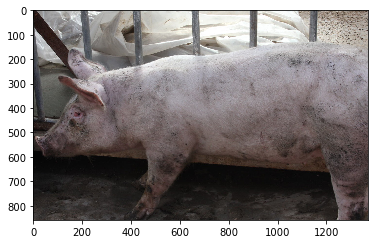

In [19]:
test_img_path = 'test_A/71.JPG'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [20]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

E:\PROJECT\Code\Sample-tranferlearning-vgg\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s


In [21]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints\pig.ckpt


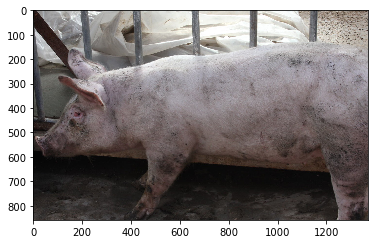

In [22]:
plt.imshow(test_img)

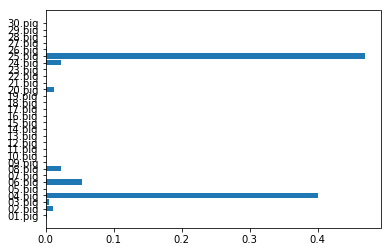

In [23]:
plt.barh(np.arange(30), prediction)
_ = plt.yticks(np.arange(30), lb.classes_)

# 输出A榜结果

In [42]:
def read_pic_name(data_dir):
    contents = os.listdir(data_dir)
    return contents

testA_dir = 'test_A/'

# 将目录名称变换为名称的list
testA_files = read_pic_name(testA_dir)
print(testA_files)

['10.JPG', '100.JPG', '1000.JPG', '1001.JPG', '1004.JPG', '1005.JPG', '1006.JPG', '1007.JPG', '1009.JPG', '1012.JPG', '1013.JPG', '1014.JPG', '1017.JPG', '1019.JPG', '1020.JPG', '1021.JPG', '1024.JPG', '1025.JPG', '1027.JPG', '1029.JPG', '103.JPG', '1030.JPG', '1033.JPG', '1034.JPG', '1035.JPG', '1037.JPG', '1039.JPG', '104.JPG', '1044.JPG', '1046.JPG', '1048.JPG', '1049.JPG', '1050.JPG', '1056.JPG', '1058.JPG', '1059.JPG', '106.JPG', '1060.JPG', '1062.JPG', '1063.JPG', '1064.JPG', '1070.JPG', '1073.JPG', '1074.JPG', '1075.JPG', '1077.JPG', '1078.JPG', '1079.JPG', '1080.JPG', '1084.JPG', '1085.JPG', '1086.JPG', '1087.JPG', '1088.JPG', '1091.JPG', '1092.JPG', '1093.JPG', '1095.JPG', '1096.JPG', '1097.JPG', '1100.JPG', '1102.JPG', '1104.JPG', '1105.JPG', '1106.JPG', '1112.JPG', '1113.JPG', '1115.JPG', '1116.JPG', '1119.JPG', '1121.JPG', '1122.JPG', '1128.JPG', '1129.JPG', '113.JPG', '1131.JPG', '1136.JPG', '1138.JPG', '1139.JPG', '114.JPG', '1141.JPG', '1142.JPG', '1145.JPG', '1146.JPG',

In [25]:
saver = tf.train.Saver()

if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

def processed_img_with_vgg16(files_name_list, files_path, sess, batch_size = 10):
    
    codes_list = []
    batch = []
    codes = None
    
    fix_gpu_error()

    codes = None
    for ii, file in enumerate(testA_files, 1):
        # Add images to the current batch
        # utils.load_image crops the input images for us, from the center
            
        # 每次添加一张图片
        img = utils.load_image(os.path.join(files_path, file))
        # 每次处理一张图片
        batch.append(img.reshape((1, 224, 224, 3)))

        # Running the batch through the network to get the codes
        if ii % batch_size == 0 or ii == len(files_path):
            images = np.concatenate(batch)
            feed_dict = {input_: images}
            codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
        
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
            
            print(codes.shape)
    
            batch = []
            print('{} images processed'.format(ii))
    return codes

with tf.Session() as sess:
    codes = processed_img_with_vgg16(testA_files, testA_dir, sess, batch_size = 10)

"vgg" object already exists.  Will not create again.
(7, 4096)
7 images processed
(10, 4096)
10 images processed
(20, 4096)
20 images processed
(30, 4096)
30 images processed
(40, 4096)
40 images processed
(50, 4096)
50 images processed
(60, 4096)
60 images processed
(70, 4096)
70 images processed
(80, 4096)
80 images processed
(90, 4096)
90 images processed
(100, 4096)
100 images processed
(110, 4096)
110 images processed
(120, 4096)
120 images processed
(130, 4096)
130 images processed
(140, 4096)
140 images processed
(150, 4096)
150 images processed
(160, 4096)
160 images processed
(170, 4096)
170 images processed
(180, 4096)
180 images processed
(190, 4096)
190 images processed
(200, 4096)
200 images processed
(210, 4096)
210 images processed
(220, 4096)
220 images processed
(230, 4096)
230 images processed
(240, 4096)
240 images processed
(250, 4096)
250 images processed
(260, 4096)
260 images processed
(270, 4096)
270 images processed
(280, 4096)
280 images processed
(290, 4096)


2380 images processed
(2390, 4096)
2390 images processed
(2400, 4096)
2400 images processed
(2410, 4096)
2410 images processed
(2420, 4096)
2420 images processed
(2430, 4096)
2430 images processed
(2440, 4096)
2440 images processed
(2450, 4096)
2450 images processed
(2460, 4096)
2460 images processed
(2470, 4096)
2470 images processed
(2480, 4096)
2480 images processed
(2490, 4096)
2490 images processed
(2500, 4096)
2500 images processed
(2510, 4096)
2510 images processed
(2520, 4096)
2520 images processed
(2530, 4096)
2530 images processed
(2540, 4096)
2540 images processed
(2550, 4096)
2550 images processed
(2560, 4096)
2560 images processed
(2570, 4096)
2570 images processed
(2580, 4096)
2580 images processed
(2590, 4096)
2590 images processed
(2600, 4096)
2600 images processed
(2610, 4096)
2610 images processed
(2620, 4096)
2620 images processed
(2630, 4096)
2630 images processed
(2640, 4096)
2640 images processed
(2650, 4096)
2650 images processed
(2660, 4096)
2660 images processe

In [26]:
print(len(codes))
print(codes.shape)
with open('testA_codes', 'w') as f:
    codes.tofile(f)



3000
(3000, 4096)


In [34]:
with open('testA_codes') as f:
    testA_codes = np.fromfile(f, dtype=np.float32)
    print(testA_codes.shape)
    testA_codes = codes.reshape((3000, -1))

print(testA_codes.shape)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    feed = {inputs_: testA_codes}
    predictions = sess.run(predicted, feed_dict=feed).squeeze()

(12288000,)
(3000, 4096)
INFO:tensorflow:Restoring parameters from checkpoints\pig.ckpt
(3000, 30)


In [41]:
print(predictions.shape)
print(max(predictions[0]))

(3000, 30)
0.988196


In [93]:
pic_num = ''
class_num = [0] * 30
class_prob = [0] * 30
class_prob_float = np.zeros(30)

probability_total = 0.0

out_put = np.zeros((30*3000, 3))
print(out_put.shape)

import csv  

def as_num(x):
    y = '{:.6f}'.format(x) # 6f表示保留6位小数点的float型
    return(y)

with open('output.csv', 'w+', newline='') as csv_file:  
    writer = csv.writer(csv_file)  
        
    for index, name in enumerate(testA_files):
        pic_num = name.split('.')[0]
        for count, probability in enumerate(predictions[index]):
            class_num[count] = count + 1
            class_prob[count] = as_num(probability)
            class_prob_float[count] = float(class_prob[count])
            probability_total += class_prob_float[count]
#        if probability_total > 1.0:
#            fix_value = probability_total - 1.0
#            max_prob_num = np.argmax(class_prob_float)
#            class_prob[max_prob_num] = as_num(class_prob_float[max_prob_num] - fix_value)
        elif probability_total < 1.0:
            fix_value = 1.0 - probability_total
            max_prob_num = np.argmax(class_prob_float)
            class_prob[max_prob_num] = as_num(class_prob_float[max_prob_num] + fix_value)
        for count in range(30):
            writer.writerow([pic_num, str(class_num[count]), class_prob[count]])

(90000, 3)


In [59]:
print(out_put[0])

[  1.00000000e+01   1.00000000e+00   8.86515074e-04]


['1', '2', '3']
['4', '5', '6']
